# Project 4: Wrangle, assess, clean and analyse twitter data - WeRateDogs


                            Christine Shuttleworth, 1st of October 2020



## Table of Contents
- [Introduction](#intro)
- [Part I - Data wrangling](#wrangling)
    - [Twitter Archive - load csv file](#load_csv)
    - [Twitter API - access and load data via Twitter API access](#twitter_api)
    - [Download and ingest neural network predictor data using requests](#requests)
- [Part II - Assess data](#assess)
    - [Visual assessment: data overview](#visual)
    - [Programmatic assessment:](#programmatic)
        - [Data structure:](#structure)
        - [Data quality:](#quality)
    - [Summary list of data issues:](#summary_issues)
        - [Tidiness issues:](#tidy)
        - [Cleanliness issues:](#cleanliness)
- [Part III - Clean data and create twitter_archive_master.csv file](#clean)
    - [Define, code and test issue: Remove retweeted twitter posts](#def1)
    - [Define, code and test issues: Find best dog type prediction and merge this, the img_num and image_url column with df_ta dataframe. Inconsistent dog names style.](#def2)
    - [Define, code and test issue: Merge df_json columns with df_ta dataframe on the tweed_id column. Delete df_json dataframe.](#def3)
    - [Define, code and test issue: Doggo, Floofer, Pupper, Puppo columns need to be melted into one column - dog_age_category](#def4)
    - [Define, code and test issues: Wrong data types and extract source as categorical data](#def5)
    - [Define, code and test issues: Suspicious numerator and denominator rating values](#def6)
    - [Define, code and test issues: Compare hashtag data from json source and from text column, add missing values to df_ta](#def7)
    - [Define, code and test issue: Serveral variables stored in text. Text, Rating, Hashtags, Image url](#def8)
    - [Define, code and test issues: Invalid dog names as well as invalid None values in the dog name column](#def9)
    - [Define, code and test issues: Missing expanded_urls values](#def10)


- [Part IV - Analyse data](#insights)
    - [Insight 1: The most commonly rated dog type and their mean rating](#insight1) 
    - [Insight 2: The tweet with the highest favorite count and retweet count](#insight2)
    - [Insight 3: Average rating per dog age category](#insight3)
    - [Insight 4: Main sources of tweets](#insight4)
    - [Insight 5: Time analysis of mean monthly rating for ratings of single dogs](#insight5)





<a id='intro'></a>
## Introduction 

For this report, I wrangled WeRateDogs Twitter data to create interesting and trustworthy data insights and visualizations of the dog rating twitter feed. 

The twitter data will be enhanced with information of likely breed of the dog being rated, based on images available in the tweets. This data originates from a neural network image prediction data set of types of dogs.

To achieve this, I createe a solid and clean master dataset. Possible questions to ask:
- Which dog type is being rated the most often and the hightest?

Based on the analysis I created two reports:

    wrangle_report.pdf - summary of my wrangling effort
    act_report.pdf - insights and visualisation of the findings as a magazine article or blog post

<a id='wrangling'></a>
## Part 1 - Data wrangling

Set up python environment

In [1192]:
import pandas as pd
import numpy as np
import tweepy as tw
import requests
import config as cfg
import os
from pathlib import Path 
import json
from dotenv import load_dotenv
import matplotlib.pyplot as plt

%matplotlib inline
#%load_ext dotenv
#%dotenv

pd.options.display.max_rows = 999
pd.options.display.max_colwidth=500

<a id='load_csv'></a>
### Load twitter_archive_enhanced.csv and learn about the data

In [1034]:
df_ta = pd.read_csv('twitter-archive-enhanced.csv')

In [1035]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Columns:
1. tweet_id: twitter reference for this particular tweet
2. in_reply_to_status_id: twitter_id of tweet that was replied to. Tweets with NaN in this column are original tweets.
3. in_reply_to_user_id: user_id who wrote the reply 
4. timestamp: timestamp of the tweet
5. source: source of tweet - Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, TweetDeck   
6. text: text of tweet: with hashtags and URL link to tweet.
7. retweeted_status_id: twitter_id of tweet that retweeted original tweet to. Tweets with NaN in this column were not retweeted.
8. retweeted_status_user_id: user_id who retweeted
9. retweeted_status_timestamp: timestamp of the retweet 
10. expanded_urls: full URL of the original tweet                
11. rating_numerator: rating of dog ...
12. rating_denominator: ... out of this number   
13. name: dog name   
14. doggo: flag if this dog falls into the doggo category
15. floofer: flag if this dog falls into the doggo category
16. pupper: flag if this dog falls into the doggo category
17. puppo: flag if this dog falls into the doggo category 

In [1036]:
df_ta.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [1037]:
df_ta.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [1038]:
#df_ta.query('in_reply_to_status_id != "NaN"')
#df_ta.query('retweeted_status_id != "NaN"')
df_ta.query('doggo != "None"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,None,None,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,None,None,None
99,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo https://t.co/EMYIdoblMR,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872967104147763200/photo/1,https://twitter.com/dog_rates/status/872967104147763200/photo/1",12,10,None,doggo,None,None,None
108,871515927908634625,NaN,NaN,2017-06-04 23:56:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo,None,None,None
110,871102520638267392,NaN,NaN,2017-06-03 20:33:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758080503809,14,10,None,doggo,None,None,None


In [1039]:
df_ta.text[9]

'This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A'

<a id='twitter_api'></a>
### Request data from the twitter API and load it into a dataframe

Use twitter ID to request retweet count and favourite count.

https://developer.twitter.com/en/docs/labs/tweets-and-users/quick-start/get-tweets

In [1040]:
#using .env file and python-dotenv to keep access token safe
#pip install -U python-dotenv

#import os
#from pathlib import Path  # Python 3.6+ only
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

consumer_key = os.getenv("TWAPIKEY")
consumer_secret = os.getenv("TWAPISECRETKEY")

#use tweepy to access twitter API with OAuth2

auth = tw.AppAuthHandler(consumer_key, consumer_secret)

#Other option to store passkey safely:
#1. could use a python .config file and the config library to store access token e.g. with wikiart API
#response = requests.get(f'https://www.wikiart.org/en/Api/2/login?accessCode={cfg.twitter['api_key']}&secretCode={cfg.twitter['api_secret_key']')

#2. secure storage of access details with yaml
#import yaml

#with open("config.yml", 'r') as ymlfile:
#    cfg = yaml.safe_load(ymlfile)

#print(cfg[api_creds'access_code'])
#print(cfg[api_creds'secret_code'])

#3.using magic command to access variables in .env
#%env
##Get, set, or list environment variables.

##Usage:

#%env: lists all environment variables/values 
#%env var: get value for var 
#%env var val: set value for var 
#%env var=val: set value for var 
#%env var=$val: set value for var, 
    
##using python expansion if possible



In [1041]:
#Access tweets by tweet_id using .get_status() to extract favourites_count, retweet_count and write to csv file
#api.get_status('749075273010798592')._json['retweet_count']

#api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#with open('twitter_retweet_favorite_count.csv', 'a') as file:
#    file.write('tweet_id, retweet_count, favorite_count \n')
        
#    for i in df_ta['tweet_id']:
#        try:
#            api_resp = api.get_status(i)
#            rt_count=api_resp._json['retweet_count']
#            f_count=api_resp._json['favorite_count']
#            file.write(f'{i}'+','+f'{rt_count}'+','+f'{f_count}'+'\n')
#        except tweepy.TweepError:
#            file.write(f'{i}'+',,\n')


In [1042]:
df_tapi = pd.read_csv('twitter_retweet_favorite_count.csv')

In [1043]:
df_tapi.head()
df_tapi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2356 non-null   int64  
 1    retweet_count    2331 non-null   float64
 2    favorite_count   2331 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 55.3 KB


In [1044]:
## I could also write the json as text one line per tweet into a text file and extract the data later. Will do this do extract more information than we already have
## and possible missing information such as missing extended urls. 

#error_dict = {}

#api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#with open('tweet_json.txt', 'a') as file:
        
#    for i in df_ta['tweet_id']:
#        try:
#            api_resp = api.get_status(i)
#            json.dump(api_resp._json, file)
#            file.write('\n')
           
#        except tw.TweepError as e:
#            error_dict.append({'error': e, 'tweet_id':i})


In [1045]:
print(error_dict)

NameError: name 'error_dict' is not defined

In [1046]:
#Check file length to see how many tweets ids were written to file 
def file_lengthy(fname):
        with open(fname) as f:
                for i, l in enumerate(f):
                        pass
        return i + 1
print("Number of lines in the file: ",file_lengthy("tweet_json.txt"))

Number of lines in the file:  2331


In [1047]:
def check_hashtag(tw_json):
    try:
        hashtags = tw_json['entities']['hashtags'][0]['text'] 
    except IndexError:
        hashtags = np.nan
    return hashtags

def check_jpg_url(tw_json):
    try:
        jpg_url = tw_json['entities']['media'][0]['url'] 
    except KeyError:
        jpg_url = np.nan
    return jpg_url

def check_expanded_url(tw_json):
    try:
        expanded_url = tw_json['extended_entities']['media'][0]['expanded_url']
    except KeyError:
        expanded_url = np.nan
    return expanded_url   
                                  
j=0

df_json = pd.DataFrame(columns = ['tweet_id', 'favorite_count', 'retweet_count','hashtags','jpg_url_json', 'expanded_url'])

with open ('tweet_json.txt', 'r') as file:
    for line in file:
        tw_json = json.loads(line)
        j+=1

        hashtags = check_hashtag(tw_json)
        jpg_url = check_jpg_url(tw_json)
        expanded_url = check_expanded_url(tw_json)

        df_json = df_json.append({'tweet_id':tw_json['id'], 'favorite_count':tw_json['favorite_count'], 'retweet_count':tw_json['retweet_count'], \
                                 'hashtags':hashtags,'jpg_url_json':jpg_url, 'expanded_url':expanded_url}, ignore_index=True)       

print(f'Total lines in dataset:{j}')                            
#strip end of text after dataframe has been build.
#df_json.text = df_json['text'].replace(r'\d?\d\/10\s\w.*', '', inplace = True, regex=True)

Total lines in dataset:2331


In [1048]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   favorite_count  2331 non-null   object
 2   retweet_count   2331 non-null   object
 3   hashtags        19 non-null     object
 4   jpg_url_json    1816 non-null   object
 5   expanded_url    1816 non-null   object
dtypes: object(6)
memory usage: 109.4+ KB


<a id='requests'></a>
### Request data from URL and load .tsv file into dataframe 

In [1049]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
#response.content

with open('image-predictions.tsv', 'wb') as file:
    file.write(response.content)

df_pre = pd.read_csv('image-predictions.tsv', delimiter='\t')

In [1050]:
df_pre.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='assess'></a>
## Part II - Assess Data

<a id='visual'></a>
### Visual assessment: Data overview 

I have four dataframes that all link together with the tweed_id. Two dataframes contain the same data but were extracted differently: df_tapi and df_json. I will use df_json for analysis, as I have extracted extra data in this table that may be useful later on. To analyse the data, the three tables  `df_ta`, `df_json`, and `df_pre`can be merged into one dataset with information about the individual tweets in each row. The outcome of the dog predition algorithm in df_pre are interesting, but not releavnt for my analysis, apart from the most likely dog type prediction for the images send with the tweets.

Some of the columns look redundant, such as expanded twitter url. Need to check if the expansion is always the same. If yes the expanced url can be arrived at using the tweed_id. This information does not have to be stored in a column as this takes up unnecessary space.

Other columns that are not necessary are the probability columns for the second and third best predicitons. I am only interested in the best prediction of the dog type that is actually a dog.

The twitter archive dataframe - df_ta - includes columns that indicate if the tweet was a reply or not (in_reply_to_status_id, in_reply_to_user_id). These columns can be used to filter out any tweets that are not original posts and then the columns can be deleted.

The twitter archive dataframe also includes the text of the tweet, which can be split up and #hashtags, url and rating extracted and stored in separate columns. This column should really only store the text variable. 

<a id='programmatic'></a>
### Programmatic assessment 

In [1051]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [1052]:
df_ta.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [1053]:
df_tapi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2356 non-null   int64  
 1    retweet_count    2331 non-null   float64
 2    favorite_count   2331 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 55.3 KB


In [1054]:
df_tapi.describe()

,tweet_id,retweet_count,favorite_count
count,2.356000e+03,2331.000000,2331.000000
mean,7.427716e+17,2647.039468,7426.154869
std,6.856705e+16,4476.566497,11532.166948
min,6.660209e+17,1.000000,0.000000
25%,6.783989e+17,536.500000,1291.000000
50%,7.196279e+17,1237.000000,3226.000000
75%,7.993373e+17,3072.000000,9092.000000
max,8.924206e+17,76063.000000,153368.000000


In [1055]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   favorite_count  2331 non-null   object
 2   retweet_count   2331 non-null   object
 3   hashtags        19 non-null     object
 4   jpg_url_json    1816 non-null   object
 5   expanded_url    1816 non-null   object
dtypes: object(6)
memory usage: 109.4+ KB


In [1056]:
df_json.describe()

,tweet_id,favorite_count,retweet_count,hashtags,jpg_url_json,expanded_url
count,2.331000e+03,2331.0,2331.0,19,1816,1816
unique,2.331000e+03,1984.0,1673.0,16,1757,1757
top,7.423859e+17,0.0,799.0,BarkWeek,https://t.co/VGPH0TfESw,https://twitter.com/dog_rates/status/679062614270468097/photo/1
freq,1.000000e+00,163.0,5.0,3,2,2


In [1057]:
for col in df_json:
    print(f'{col}: {type(col[0])}')

tweet_id: <class 'str'>
favorite_count: <class 'str'>
retweet_count: <class 'str'>
hashtags: <class 'str'>
jpg_url_json: <class 'str'>
expanded_url: <class 'str'>


In [1058]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='structure'></a>
### Data structure: Tidiness issues

#### **Issue:** 
Retweeted_status_id, retweeted_user_id, retweeted_timestamp. Use columns to drop rows that are replies and not original ids and delete all three columns.

#### **Issue:** 
Find best prediction for each dog that is actually a dog and store it in a column. Merge this and the image_url column with df_ta dataframe. All other columns are redundant.

#### **Issue:** 
Merge `df_json` columns with `df_ta` dataframe on the `tweed_id` column. Delete `df_json`` dataframe

#### **Issue:** 
Doggo, Floofer, Pupper, Puppo columns need to be melted into one column - `dog_age_category`: which contains the category which is correct for the dog.

#### **Issue:** 
More then one variable stored in the `df_ta.text` column. Removes #tags, urls and ratings from text as these can be store or are stored in other columns. Two different urls are saved for the tweet. Once in the `df_ta.text` column and once in `df_pre.jpg_id`. The rating are stored in two separate columns: `df_ta.denominator` and `df_ta.numerator`. Endresult: the text col only contains the text with ratings and hashtags that are relevant to the semantics of the text.
    

In [1059]:
df_ta[df_ta.text.str.contains('#')].text.count()

27

In [1060]:
df_ta[df_ta.text.str.contains('https:')].text.count()

2284

In [1061]:
#df_ta.text[12]
df_ta.query('tweet_id == 892420643555336193').text[0] 

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [1062]:
pd.options.display.max_colwidth=100
df_ta.query('tweet_id == 871102520638267392').expanded_urls ##the /photo/1 does not work. This url returns the tweet itself.

110    https://twitter.com/animalcog/status/871075758080503809
Name: expanded_urls, dtype: object

<a id="quality"></a>
## Data quality: 

#### **Issue:** 
wrong datatypes:

             df_ta: timestamp, source (category), retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp
         
             df_json: tweet_id, retweet_count, favorite_count

#### **Issue:** 
suspicious rating_numerators (< 8 and > 15)

In [1063]:
df_ta.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

#### **Issue:** 
suspicious denominator values. Especially 110, 120, etc. which most likely have been read in with a zero too much.

In [1064]:
df_ta.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### **Issue:** 
Source should be a categorical column as there are only 4 options: 
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11

Should be stored as: 'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck'. The href for these categories can be stored elsewhere.

#### **Issue**: 
Image url is stored twice. End of text and in df_json

#### **Issue:** 
Missing value in expanded_urls column. This data is stored in the json file and can be extracted to be added. 

#### **Issue:** 
Check dog names count_values. Wrong dog names. See if I can restore these names from the text.

In [1065]:
df_ta.name.value_counts()
#sorted(df_ta.name.unique()) -- this will sort out all the lower letter dog names that are invalid to the end of the list

None              745
a                  55
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Tucker             10
Lola               10
Penny              10
Winston             9
Bo                  9
the                 8
Sadie               8
Daisy               7
Buddy               7
Toby                7
Bailey              7
an                  7
Koda                6
Dave                6
Leo                 6
Oscar               6
Jax                 6
Scout               6
Bella               6
Milo                6
Rusty               6
Jack                6
Stanley             6
Sammy               5
Phil                5
Oakley              5
Bentley             5
Sunny               5
very                5
Louis               5
Gus                 5
George              5
Alfie               5
Finn                5
Larry               5
Chester             5
Duke                4
Brody               4
Dexter              4
Cassie    

#### **Issue:** 
`None`values in the name column are string and are not being picked up as None values in the dataframe.

#### **Issue:** 
`df_ta.text` contains sometimes two dogs and only one name is stored but both dog categories. Or it refers to two categories of dogs, e.g. doggo 1, pupper 0. Where both categories are set to true. 

In [1066]:
df_ta.query('doggo == "doggo" and pupper =="pupper"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths ...,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/st...",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your aver...,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/st...",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/st...",12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/st...",12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 wo...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/st...",12,10,Maggie,doggo,None,pupper,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,doggo,None,pupper,None


#### **Issue:** 
Predicted dog names are written inconsistently. Should be without `-` and capitalised.

<a id='clean'></a>
## Part III - Clean data and create twitter_archive_master.csv file

<a id="def1"> </a>
### Define issue: Remove retweeted twitter posts

The columns `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` store retweets, that I do not want to investigate. Drop rows with data from retweets, i.e. where retweet_status_status_id is not Null and then drop all three columns from the table

### Code issue:

In [1067]:
df_ta = df_ta.query('retweeted_status_id == "NaN"')
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [1068]:
df_ta.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

### Test issue:

In [1069]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

<a id=def2> </a>
### Define Issues: Find best dog type prediction and merge this, the img_num and image_url column with df_ta dataframe. Change inconsistent ways of writing dog names.

In [1070]:
df_pre.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


The `df_pre`table contains three predictions of what type of dog is likely to be shown on the image. Delete all data where all three predictions are not a dog. Insert column final_prediction and set to dog 1. Then use a mask to set final prediction to dog 2 if dog 1 is False. And finally set it to dog 3 if dog 2 is False using .mask(). While I am working on this table, I have also changed the dog names to a consistend format.

<a id=code2> </a>
### Code Issue: 

In [1071]:
df_pre = df_pre.query('p1_dog == True or p2_dog == True or p3_dog == True')
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1751 non-null   int64  
 1   jpg_url   1751 non-null   object 
 2   img_num   1751 non-null   int64  
 3   p1        1751 non-null   object 
 4   p1_conf   1751 non-null   float64
 5   p1_dog    1751 non-null   bool   
 6   p2        1751 non-null   object 
 7   p2_conf   1751 non-null   float64
 8   p2_dog    1751 non-null   bool   
 9   p3        1751 non-null   object 
 10  p3_conf   1751 non-null   float64
 11  p3_dog    1751 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


In [1072]:
## find the best prediction
df_pre['dog_type'] = df_pre['p1']
df_pre['dog_type_flag'] = df_pre.p1_dog
df_pre['dog_type'] = df_pre['dog_type'].mask(df_pre.dog_type_flag == False, df_pre['p2'])
df_pre['dog_type_flag'] = df_pre['dog_type_flag'].mask(df_pre.dog_type_flag == False, df_pre['p2_dog'])
df_pre['dog_type'] = df_pre['dog_type'].mask(df_pre.dog_type_flag == False, df_pre['p3'])
df_pre['dog_type_flag'] = df_pre['dog_type_flag'].mask(df_pre.dog_type_flag == False, df_pre['p3_dog'])

df_pre.dog_type_flag.value_counts()
#df_pre.dog_type.value_counts()

True    1751
Name: dog_type_flag, dtype: int64

In [1073]:
## Change dog name format
df_pre['dog_type'] = df_pre['dog_type'].str.replace('_', ' ')
df_pre['dog_type'] = df_pre['dog_type'].apply(lambda x: x.title())
df_pre_short = df_pre[['tweet_id', 'jpg_url', 'img_num', 'dog_type']]

df_pre_short.head(50)

,tweet_id,jpg_url,img_num,dog_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese Mountain Dog
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Golden Retriever
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature Poodle
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,Golden Retriever


In [1074]:
df_ta = pd.merge(df_ta, df_pre_short, how = 'left', on='tweet_id')

<a id=test2> </a>
### Test Issue: 

In [1075]:
df_ta.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Labrador Retriever
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset


<a id='def3'></a>
### Define Issue: Merge df_json columns with df_ta dataframe on the tweed_id column. Delete df_json dataframe

The table df_json can not be merged yet, as the datatypes of the twitter_id is string. Need to convert this to int64 so that merging is possible. While I am already changing datatypes, I am also changing favorite_count and retweet_count to int64.

<a id='clean3'></a>
### Code Issue:

In [1076]:
df_json.tweet_id = df_json.tweet_id.astype('int64')
df_json.favorite_count = df_json.favorite_count.astype('int64')
df_json.retweet_count = df_json.retweet_count.astype('int64')

In [1077]:
df_ta = pd.merge(df_ta, df_json, how='left', on='tweet_id')

In [1078]:
del df_json

<a id='test3'></a>
### Test Issue:

In [1079]:
#df_json.info()
df_ta.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,pupper,puppo,jpg_url,img_num,dog_type,favorite_count,retweet_count,hashtags,jpg_url_json,expanded_url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,...,None,None,NaN,NaN,NaN,35568.0,7523.0,NaN,https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,...,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,...,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,23141.0,3701.0,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,...,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Labrador Retriever,38857.0,7711.0,NaN,https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,...,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,37132.0,8308.0,NaN,NaN,NaN


<a id='def4'></a>
### Define issues: Doggo, Floofer, Pupper, Puppo columns need to be melted into one column - dog_age_category


Doggo, Floofer, Pupper, Puppo are categories of dogs, that can be melted into one column - dog_age_category using melt(). The value of the dog_age_category is 'Fluffer', 'Pupper' etc. Need to be careful as some comments talk about more than one dog and more than one category can then be set to True. Or sometimes two age categories are referenced but only one applies to the dog. Therefore I will first delete all rows that have two dog age categories set to true, as I don't know which one is the correct one for the main dog, listed in dog name.

<a id='code4'></a>
### Code issue: 

In [1080]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  jpg_url                1686 non-null   object 
 15  img_

In [1081]:
##Extract all data with dog_category values into a separate table to melt()
df_ta_dog_age = df_ta.query('doggo == "doggo" or floofer == "floofer" or pupper =="pupper" or puppo =="puppo" ')
df_ta_dog_age = df_ta_dog_age.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 'in_reply_to_status_id', 'in_reply_to_user_id','expanded_urls', 'rating_numerator', 'rating_denominator', \
            'name', 'jpg_url', 'img_num', 'dog_type', 'favorite_count', 'retweet_count', 'hashtags', 'jpg_url_json', 'expanded_url'], var_name='dog_age_category', value_name='dog_age')


In [1082]:
##Delete extra rows generated by melt to keep only the ones that have a dog_age value
df_ta_dog_age = df_ta_dog_age.query('dog_age != "None"')
df_ta_dog_age
##delete dog_age column as dog_age_category has all the information that we need
df_ta_dog_age.drop(columns = 'dog_age', inplace = True)

In [1083]:
df_ta_dog_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 1199
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               356 non-null    int64  
 1   timestamp              356 non-null    object 
 2   source                 356 non-null    object 
 3   text                   356 non-null    object 
 4   in_reply_to_status_id  9 non-null      float64
 5   in_reply_to_user_id    9 non-null      float64
 6   expanded_urls          350 non-null    object 
 7   rating_numerator       356 non-null    int64  
 8   rating_denominator     356 non-null    int64  
 9   name                   356 non-null    object 
 10  jpg_url                270 non-null    object 
 11  img_num                270 non-null    float64
 12  dog_type               270 non-null    object 
 13  favorite_count         318 non-null    float64
 14  retweet_count          318 non-null    float64
 15  hasht

In [1084]:
##drop data with dog type information in the df_at table and add data from df_ta_dog_age table to original table.

In [1085]:
df_ta = df_ta.query('doggo != "doggo" and floofer != "floofer" and pupper !="pupper" and puppo != "puppo"')
#df_ta.puppo.value_counts()
df_ta = df_ta.drop(columns=['doggo', 'pupper', 'puppo', 'floofer'])

In [1086]:
##find duplicates for dogs that have two categories in df_ta_dog_age: (Reset index to be able to identify the duplicate columns that need to be dropped)
df_ta_dog_age.reset_index(inplace = True) 
tweet_ids_with_two_dog_cats = df_ta_dog_age[df_ta_dog_age.tweet_id.duplicated()].sort_values('tweet_id').tweet_id

In [1087]:
#df_ta_dog_age.query('tweet_id in @tweet_ids_with_two_dog_cats').sort_values('tweet_id') - 13 Duplicates
df_ta_dog_age.query('tweet_id in @tweet_ids_with_two_dog_cats').sort_values('tweet_id').index

Int64Index([ 81, 169,  77, 162,  68, 147,  60, 143,  50, 132,  46, 131,  39,
            126,  38, 125,  37, 122, 117,  32,   8,  88,   7, 337],
           dtype='int64')

In [1088]:
##Rows to delete as they are the wrong category for this dog or because there are two dogs and two categories, so one is being deleted:

df_ta_dog_age.drop(index=[196,83,75,67,62,57,54,151,96,42,37,8,7], inplace=True)

#Rows to update - for all the tweets with two dogs, the dog_age_category is being set to "":
df_ta_dog_age.loc[87,'dog_age_category'] = ''
df_ta_dog_age.loc[189,'dog_age_category'] = ''
df_ta_dog_age.loc[174,'dog_age_category'] = '' # delete this as there is no dog on this?
df_ta_dog_age.loc[169,'dog_age_category'] = ''
df_ta_dog_age.loc[164,'dog_age_category'] = ''
df_ta_dog_age.loc[159,'dog_age_category'] = ''
df_ta_dog_age.loc[137,'dog_age_category'] = ''


In [1089]:
df_ta['dog_age_category']=np.nan
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1831 entries, 0 to 2174
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1831 non-null   int64  
 1   in_reply_to_status_id  70 non-null     float64
 2   in_reply_to_user_id    70 non-null     float64
 3   timestamp              1831 non-null   object 
 4   source                 1831 non-null   object 
 5   text                   1831 non-null   object 
 6   expanded_urls          1779 non-null   object 
 7   rating_numerator       1831 non-null   int64  
 8   rating_denominator     1831 non-null   int64  
 9   name                   1831 non-null   object 
 10  jpg_url                1426 non-null   object 
 11  img_num                1426 non-null   float64
 12  dog_type               1426 non-null   object 
 13  favorite_count         1698 non-null   float64
 14  retweet_count          1698 non-null   float64
 15  hash

In [1090]:
 ## create new column on df_ta: `dog_age_category` and merge data from df_ta_dog_age to df_ta using outerjoin to add the melted data back to the original dataframe
df_ta = df_ta.append(df_ta_dog_age, ignore_index=True)
df_ta = df_ta.drop(columns='index')

<a id='test4'></a>
### Test issue: 

In [1091]:
df_ta_dog_age.info()
df_ta.query('tweet_id in (@tweet_ids_with_two_dog_cats ) ')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343 entries, 0 to 355
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  343 non-null    int64  
 1   tweet_id               343 non-null    int64  
 2   timestamp              343 non-null    object 
 3   source                 343 non-null    object 
 4   text                   343 non-null    object 
 5   in_reply_to_status_id  8 non-null      float64
 6   in_reply_to_user_id    8 non-null      float64
 7   expanded_urls          338 non-null    object 
 8   rating_numerator       343 non-null    int64  
 9   rating_denominator     343 non-null    int64  
 10  name                   343 non-null    object 
 11  jpg_url                259 non-null    object 
 12  img_num                259 non-null    float64
 13  dog_type               259 non-null    object 
 14  favorite_count         307 non-null    float64
 15  retwee

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,dog_type,favorite_count,retweet_count,hashtags,jpg_url_json,expanded_url,dog_age_category
1861,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow ...",https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,https://pbs.twimg.com/ext_tw_video_thumb/817777588030476288/pu/img/KbuLpE4krHF4VdPf.jpg,1.0,Curly-Coated Retriever,NaN,NaN,NaN,NaN,NaN,doggo
1866,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,https://pbs.twimg.com/media/CyI3zXgWEAACQfB.jpg,1.0,Labrador Retriever,6777.0,1378.0,NaN,https://t.co/9IxWAXFqze,https://twitter.com/dog_rates/status/802265048156610565/photo/1,doggo
1867,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths ...,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/st...",12,10,Bones,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1.0,Dalmatian,8091.0,2108.0,NaN,NaN,NaN,doggo
1873,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your aver...,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/st...",10,10,Pinot,NaN,NaN,NaN,7858.0,2241.0,NaN,NaN,NaN,doggo
1877,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5rgu2Law2ut,12,10,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,doggo
1885,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 wo...","https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/st...",12,10,Maggie,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2.0,Golden Retriever,5882.0,1881.0,NaN,https://t.co/MYwR4DQKll,https://twitter.com/dog_rates/status/759793422261743616/photo/1,doggo
1891,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/1...,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1.0,Dalmatian,4329.0,1080.0,NaN,https://t.co/u2c9c7qSg8,https://twitter.com/dog_rates/status/751583847268179968/photo/1,doggo
1899,741067306818797568,NaN,NaN,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12,10,just,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1.0,Golden Retriever,9346.0,3024.0,NaN,https://t.co/o5J479bZUC,https://twitter.com/dog_rates/status/741067306818797568/photo/1,doggo
1903,733109485275860992,NaN,NaN,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone

In [1092]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2174 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2174 non-null   object 
 4   source                 2174 non-null   object 
 5   text                   2174 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2174 non-null   int64  
 8   rating_denominator     2174 non-null   int64  
 9   name                   2174 non-null   object 
 10  jpg_url                1685 non-null   object 
 11  img_num                1685 non-null   float64
 12  dog_type               1685 non-null   object 
 13  favorite_count         2005 non-null   float64
 14  retweet_count          2005 non-null   float64
 15  hash

  <a id="def5"> </a>
### Define issue: Wrong data types and extract source as categorical data

             timestamp - timestamp
             source  - category, 
             in_reply_to_status_id  - int64,
             in_reply_to_user_id - int64, 
             img_num  - int64
             favorite_count - int_64
             retweet_count - int_64
             dog_age_category - category
             

  <a id="codeq1"> </a>
### Code issue:

In [1093]:
df_ta.timestamp = pd.to_datetime(df_ta.timestamp)
df_ta.in_reply_to_status_id = df_ta.in_reply_to_status_id.astype('Int64')
df_ta.in_reply_to_user_id = df_ta.in_reply_to_user_id.astype('Int64')
df_ta.img_num = df_ta.img_num.astype('Int64')
df_ta.favorite_count = df_ta.favorite_count.astype('Int64')
df_ta.retweet_count = df_ta.retweet_count.astype('Int64')
df_ta.dog_age_category = df_ta.dog_age_category.astype('category')
df_ta.rating_numerator = df_ta.rating_numerator.astype('float')
df_ta.rating_denominator = df_ta.rating_denominator.astype('float')

In [1094]:
#extract source tag from a href.
#<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a> is going to be `Twitter for iPhone``
#<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>  is going to be `Vine - Make a Scene`
#<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>  is going to be `Twitter Web Client`
#<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a> is going to be `TweetDeck`

df_ta.source = df_ta.source.str.extract(r'((?:<a href=".*">)(.*)<.)', expand=True)[1]
df_ta.source.value_counts()
df_ta.source = df_ta.source.astype('category')

  <a id="testq1"> </a>
### Test issue:

In [1095]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2174 non-null   int64              
 1   in_reply_to_status_id  78 non-null     Int64              
 2   in_reply_to_user_id    78 non-null     Int64              
 3   timestamp              2174 non-null   datetime64[ns, UTC]
 4   source                 2174 non-null   category           
 5   text                   2174 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2174 non-null   float64            
 8   rating_denominator     2174 non-null   float64            
 9   name                   2174 non-null   object             
 10  jpg_url                1685 non-null   object             
 11  img_num                1685 non-null   Int64            

In [1377]:
df_ta.timestamp.min(), df_ta.timestamp.max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

<a id='def6'></a>
### Defining issue: Suspicious numerator and denominator rating values

Denominators of the ratings should always be 10, as the rating is out of 10. For Numerator values there are some very high and low values. For some it looks like a 0 has been added on the end by mistake. Check original text to see what the rating was and trim excess rating or extract ratings again and store as ratings_numerator and ratings_denominator

<a id='codeq2'></a>
### Code issue:

In [1096]:
pd.options.display.max_colwidth=1000
df_ta.rating_numerator.value_counts().index.sort_values()
df_ta[['tweet_id','text', 'rating_numerator']].query('rating_numerator > 15')

,tweet_id,text,rating_numerator
45,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17.0
140,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420.0
141,855860136149123072,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666.0
217,838150277551247360,@markhoppus 182/10,182.0
230,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0
305,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0
358,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0
466,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0
610,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0
661,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0


In [1097]:
#often more than one dog and then they are rated out of 50 if there are five dogs etc. Not a good idea using loc as this needs to be redone when dataframe changes. Should
#use tweet_id
df_ta.loc[37,'rating_numerator'] = 13.5
df_ta.loc[45,'rating_numerator'] = 13
df_ta.loc[230,'rating_numerator'] = 13
df_ta.loc[276,'rating_numerator'] = 9.75
df_ta.loc[358,'rating_numerator'] = np.nan
df_ta.loc[466,'rating_numerator'] = 9.75
df_ta.loc[830,'rating_numerator'] = 11
df_ta.loc[1207,'rating_numerator'] = np.nan
df_ta.loc[1248,'rating_numerator'] = 11.26
df_ta.loc[1955,'rating_numerator'] = 11.27

df_ta.loc[249,'rating_numerator'] = np.nan
df_ta.loc[1161, 'rating_numerator'] = np.nan
df_ta.loc[800, 'rating_numerator'] = 13
df_ta.loc[1050, 'rating_numerator'] = 13
df_ta.loc[1206, 'rating_numerator'] = 10
df_ta.loc[1227, 'rating_numerator'] = 9.5
df_ta.loc[1089, 'rating_numerator'] = 10
df_ta.loc[1810, 'rating_numerator'] = 9

In [1098]:
df_ta.rating_denominator.value_counts().index.sort_values()
df_ta[['text', 'rating_denominator']].query('rating_denominator > 10')

,text,rating_denominator
249,@docmisterio account started on 11/15/15,15.0
305,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70.0
610,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150.0
726,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11.0
765,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170.0
800,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20.0
830,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0
855,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90.0
877,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0
896,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50.0


In [1099]:
df_ta.loc[249,'rating_denominator'] = np.nan
df_ta.loc[230,'rating_denominator'] = 10
df_ta.loc[726,'rating_denominator'] = 10
df_ta.loc[800, 'rating_denominator'] = 10
df_ta.loc[830, 'rating_denominator'] = 10
df_ta.loc[1161, 'rating_denominator'] = np.nan
df_ta.loc[1206, 'rating_denominator'] = 10
df_ta.loc[1810, 'rating_denominator'] = 10
df_ta.loc[358, 'rating_denominator'] = np.nan
df_ta.loc[1207, 'rating_denominator'] = np.nan

In [1100]:
df_ta[['text', 'rating_numerator']].query('rating_numerator < 8');
#some of the lower values where picked up wrongly. These updates have been added above

In [1101]:
df_ta[['text', 'rating_denominator']].query('rating_denominator < 10') 

,text,rating_denominator


<a id='testq2'></a>
### Test issues:

In [1102]:
pd.options.display.max_colwidth=1000
df_ta[['text', 'rating_numerator']].query('rating_numerator > 15') 

,text,rating_numerator
140,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420.0
141,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666.0
217,@markhoppus 182/10,182.0
305,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0
610,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0
661,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0
765,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0
855,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0
877,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0
896,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0


In [1103]:
df_ta[['text', 'rating_denominator']].query('rating_denominator < 10 or rating_denominator > 10') 

,text,rating_denominator
305,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70.0
610,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150.0
765,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170.0
855,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90.0
877,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0
896,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50.0
962,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50.0
1030,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,40.0
1186,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",130.0
1187,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,110.0


<a id='def7'></a>
### Defining issue: Compare hashtag data from json source and from text column, add missing values to df_ta

Hashtag data has been extracted from Json data, compare with hashtags in the text column and add missing values to hashtag column

### Code issue:

In [1104]:
hashtaglist = df_ta.hashtags.value_counts()
tweet_id_hashtags = df_ta[['hashtags', 'tweet_id']].query('hashtags in @hashtaglist.index').tweet_id

In [1105]:
tweet_id_text = df_ta[df_ta.text.str.contains('#')].tweet_id
#8 hashtags more than I extracted from the json file
#rename jpg_url_json into jpg_url_short

def find_missing_hashtags (tweet_ids_text, tweet_ids_hashtags):
    
        dif1 = set(tweet_ids_text).difference(tweet_ids_hashtags)
        dif2 = set(tweet_ids_hashtags).difference(tweet_ids_text)
        
        return list(dif1)+ list(dif2)

update_hashtags = find_missing_hashtags(tweet_id_text, tweet_id_hashtags)    
    
    
    

In [1106]:
df_ta[['tweet_id','text', 'hashtags']].query('tweet_id in @update_hashtags')


,tweet_id,text,hashtags
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN
8,890609185150312448,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN
9,890006608113172480,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,NaN
12,889278841981685760,This is Oliver. You're witnessing one of his many brutal attacks. Seems to be playing with his victim. 13/10 fr*ckin frightening #BarkWeek https://t.co/WpHvrQedPb,NaN
46,881268444196462592,Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet https://t.co/cgwJwowTMC,NaN
2150,889531135344209921,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,NaN
2152,874012996292530176,"This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V",NaN


In [1107]:
##manually change: 881268444196462592 #Canada, 874012996292530176 #PrideMonth, all others are BarkWeek Hashtags

df_ta['hashtags'] = df_ta[['tweet_id', 'hashtags']].mask(df_ta['tweet_id'] == 881268444196462592, "Canada").hashtags
df_ta['hashtags'] = df_ta[['tweet_id', 'hashtags']].mask(df_ta['tweet_id'] == 874012996292530176, "PrideMonth").hashtags

##run update_hashtags again to get only 'BarkWeek' hashtags and update
for i in update_hashtags:
    if i not in [881268444196462592,874012996292530176]:
        df_ta ['hashtags'] = df_ta[['tweet_id', 'hashtags']].mask(df_ta['tweet_id'] == i, "BarkWeek").hashtags

### Test issue:

In [1108]:
df_ta[['tweet_id','text', 'hashtags']].query('tweet_id in @update_hashtags')

,tweet_id,text,hashtags
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",BarkWeek
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,BarkWeek
8,890609185150312448,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,BarkWeek
9,890006608113172480,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,BarkWeek
12,889278841981685760,This is Oliver. You're witnessing one of his many brutal attacks. Seems to be playing with his victim. 13/10 fr*ckin frightening #BarkWeek https://t.co/WpHvrQedPb,BarkWeek
46,881268444196462592,Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet https://t.co/cgwJwowTMC,Canada
2150,889531135344209921,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,BarkWeek
2152,874012996292530176,"This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V",PrideMonth


<a id='def8'></a>
### Defining issue: Serveral variables stored in text. Text, Rating, Hashtags, Image url

All extra variable that is stored in the text column are available in other columns. The image urls extracted from the json file and ingested are however not complete. Extract the short image urls from the text to get a more complete dataset.  Rating, Url, Hashtags and Image url can then be deleted from the text column. The rating will only be stripped if it is at the end and not part of the text synthax. Use regular expressions and replace with empty string. '(\d{2,3}/\d{2,3}\s#?.*)'. Some text have no rating. In these lines only the link will be stripped.

In [1109]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2174 non-null   int64              
 1   in_reply_to_status_id  78 non-null     Int64              
 2   in_reply_to_user_id    78 non-null     Int64              
 3   timestamp              2174 non-null   datetime64[ns, UTC]
 4   source                 2174 non-null   category           
 5   text                   2174 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2170 non-null   float64            
 8   rating_denominator     2170 non-null   float64            
 9   name                   2174 non-null   object             
 10  jpg_url                1685 non-null   object             
 11  img_num                1685 non-null   Int64            

### Code issue:

In [1110]:
pd.options.display.max_colwidth=1000
##Extract short image urls
df_ta['jpg_short'] = df_ta.text.str.extract(r'(https://.*)', expand=True)

##The extracted short image urls are a lot more complete than the short image urls extracted from the Json file. Delete jgp_url_json from the table.
df_ta[['jpg_url_json','jpg_short']].head(10)
df_ta.drop(columns='jpg_url_json', inplace=True)

In [1410]:
df_ta.text.replace(r'\s?(\d?\d?\d?/\d?\d?\d?\s)?(#[A-Z,a-z]*\s?)?(https://.*)', value='', regex=True, inplace=True)

#r'\s?(\d?\d?\d?/\d?\d?\d?\s)?(#[A-Z]*[a-z]*[A-Z]*[a-z]*\s?)?(https://.*)  - works for ratings, hashtags and https

#(#[A-Z]*[a-z]*[A-Z]*[a-z]*\s?)?(https://.*) - works for https and Hashtags

#strip \n from the end

df_ta.text = df_ta.text.str.strip()

### Test issue:

In [1112]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2174 non-null   int64              
 1   in_reply_to_status_id  78 non-null     Int64              
 2   in_reply_to_user_id    78 non-null     Int64              
 3   timestamp              2174 non-null   datetime64[ns, UTC]
 4   source                 2174 non-null   category           
 5   text                   2174 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2170 non-null   float64            
 8   rating_denominator     2170 non-null   float64            
 9   name                   2174 non-null   object             
 10  jpg_url                1685 non-null   object             
 11  img_num                1685 non-null   Int64            

In [1113]:
pd.options.display.max_colwidth=1000
df_ta[df_ta.text.str.contains('https:')].text

Series([], Name: text, dtype: object)

In [1114]:
pd.options.display.max_colwidth=1000
df_ta[df_ta.text.str.contains('#')].text

46       Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet
76          Here are my favorite #dogsatpollingstations \nMost voted for a more consistent walking schedule and to increase daily pats tenfold. All
77                             This is Monkey. She's supporting owners everywhere with her fancy #PrideMonth bandana. 13/10 love is love is love...
81               Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner.
201                         Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all
412                                                                                                                                     #ImWithThor
668                                  #BarkWeek is getting rather heckin terrifying over here. Doin me quite the 

In [1115]:
df_ta[df_ta.text.str.contains('/10')].text.head(100)


3                                                                   This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
5                  Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo)
6                               Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below
9                          This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting
10                                      This is Bruno. He is a service shark. Only gets out of the water to assist you. 13/10 terrifyingly good boy
11                                                      This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist
12                 This is Oliver. You're witnessing one of his many brutal attacks. Seems to be playing with hi

<a id='def9'></a>
### Define issue: Invalid dog names as well as invalid None values in the dog name column
Some dogs names are stored as: a, the, one, quite, mad, not, 0, life, space, this, by, officially, old, his, such, inacceptable, my, all, incredibly. These have been extracted incorrectly. I could try and re-extract them using regex (most dog names have a certain introduction: "This is ..." "Meet ...", But since there are not many values, with invalid dog names, I will look at them manually and update where necessary using mask() on the the tweet_id and checking the text column for valid dog name.


### Code issue:

In [1116]:
df_ta.query('name == "O"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,dog_type,favorite_count,retweet_count,hashtags,expanded_url,dog_age_category,jpg_short
518,776201521193218049,<NA>,<NA>,2016-09-14 23:30:38+00:00,Twitter for iPhone,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af,https://twitter.com/dog_rates/status/776201521193218049/photo/1,10.0,10.0,O,https://pbs.twimg.com/media/CsWfKadWEAAtmlS.jpg,1,Rottweiler,9576,2508,NaN,https://twitter.com/dog_rates/status/776201521193218049/photo/1,NaN,https://t.co/Pq150LeRaC


In [1117]:
##Extracted invalid dog names in the assessment part by hand. Could have extracted them automatically as they are all start with lower case letters apart from O which I will look at separately.
invalid_dog_name=['a',
 'actually',
 'all',
 'an',
 'by',
 'getting',
 'incredibly',
 'infuriating',
 'just',
 'life',
 'light',
 'mad',
 'not',
 'officially',
 'old',
 'one',
 'quite',
 'space',
 'such',
 'the',
 'this',
 'unacceptable',
 'very']
##for all invalid dog names find out if there are dog names that have been missed in the text manually using the commented out code.
for i in invalid_dog_name:
    print(df_ta.query('name== @i')[['tweet_id', 'text', 'name']])
    
update_name_dict= {748692773788876800:'Quizno',
765395769549590528:'Zoey',
675706639471788032:'Wylie',
673636718965334016:'Kip',
671743150407421952:'Jacob',
671147085991960577:'Rufus',
670427002554466305:'Spork',
670361874861563904:'Cherokee',
670303360680108032:'Hemry',
669923323644657664:'Alphred',
669564461267722241:'Alfredo',
668955713004314625:'Leroi',
668507509523615744:'Chuk',
668171859951755264:'Alfonso',
667861340749471744:'Cheryl',
667773195014021121:'Jessiga',
667538891197542400:'Klint',
667470559035432960:'Kohl',
667177989038297088:'Daryl',
666983947667116034:'Pepe',
666781792255496192:'Octaviath',
666701168228331520:'Johm',
668636665813057536:'Berta',
776201521193218049:"O'Malley"}

In [1118]:
for k, v in update_name_dict.items():
    df_ta.name = df_ta['name'].mask(df_ta['tweet_id'] == k, v)

In [1119]:
##Replace all dog names that start with a lower letter with None.
#df_ta.query('name in @invalid_dog_name').name.count()

df_ta.name = df_ta.name.apply(lambda i: None if i in invalid_dog_name else i)

##convert None text values to None values
df_ta.name = df_ta.name.apply(lambda i: None if i == 'None' else i)

### Test issue:

In [1120]:
tweet_ids_updated = list(update_name_dict.keys())
df_ta[['tweet_id', 'name']].query('tweet_id in @tweet_ids_updated')

,tweet_id,name
518,776201521193218049,O'Malley
573,765395769549590528,Zoey
1361,675706639471788032,Wylie
1448,673636718965334016,Kip
1511,671743150407421952,Jacob
1543,671147085991960577,Rufus
1593,670427002554466305,Spork
1602,670361874861563904,Cherokee
1605,670303360680108032,Hemry
1623,669923323644657664,Alphred


In [1121]:
#df_ta.query('name in @invalid_dog_name').name.count()
df_ta.name.unique()
##Check None values are now real None values and not text strings.
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2174 non-null   int64              
 1   in_reply_to_status_id  78 non-null     Int64              
 2   in_reply_to_user_id    78 non-null     Int64              
 3   timestamp              2174 non-null   datetime64[ns, UTC]
 4   source                 2174 non-null   category           
 5   text                   2174 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2170 non-null   float64            
 8   rating_denominator     2170 non-null   float64            
 9   name                   1415 non-null   object             
 10  jpg_url                1685 non-null   object             
 11  img_num                1685 non-null   Int64            

<a id='def10'></a>
### Define issue: Missing value in expanded_urls column. This data is stored in the json file and can be extracted to be added.

Found that there has been no additional data extracted from the JSON file but actually less than is in the file already. Delete the column that was created from the JSON extract - expanded_url.


In [1129]:
df_ta.drop('expanded_url', axis = 1, inplace=True)

### Write clean master data in the df_ta datatable to csv file: `twitter_archive_master.csv`

In [1130]:
df_ta.to_csv('twitter_archive_master.csv', index=False )

<a id='insights'></a>
## Part IV - Analyse data

<a id='insight1'></a>
### Insight: The most commonly rated dog type and their mean rating (excluding ratings for multiple dogs, i.e. only ratings out of 10)

In [1411]:
df_count = df_ta.query('rating_denominator == 10 and dog_type.notnull()').groupby(df_ta.dog_type).count().rating_numerator.sort_values(ascending=False)
df_count =pd.DataFrame(df_count)
df_count.rename(columns={'rating_numerator':'rating_count'}, inplace=True)

In [1412]:
df_avg = df_ta.query('rating_denominator == 10 and dog_type.notnull()').groupby(df_ta.dog_type).mean().rating_numerator.sort_values(ascending=False)
df_avg =pd.DataFrame(df_avg)
df_avg.rename(columns={'rating_numerator':'avg_rating'}, inplace=True)

In [1413]:
df_count = df_count.merge(df_avg, how='right', on='dog_type').sort_values('rating_count', ascending=False);

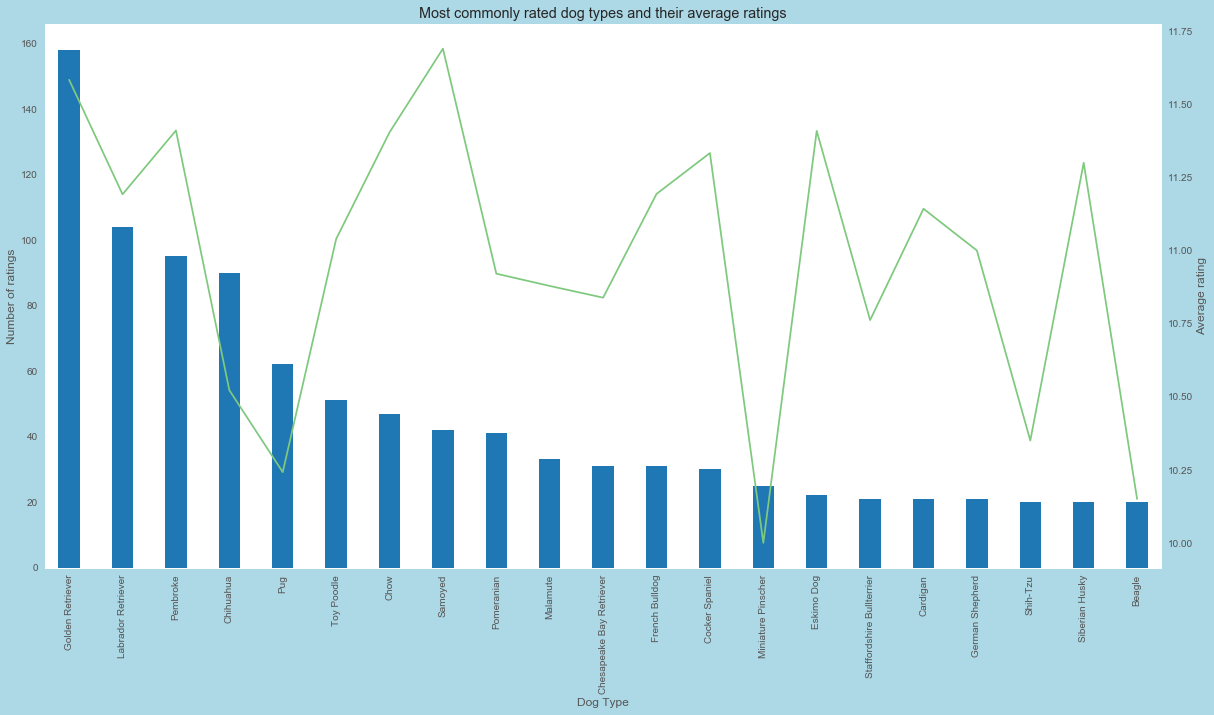

In [1414]:
fig, ax = plt.subplots(figsize = (20,10),facecolor='lightblue')

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_count.query('rating_count > 19').rating_count.plot(kind='bar', colormap='tab10', grid=False,ax=ax, width=width)
df_count.query('rating_count > 19').avg_rating.plot(kind='line', colormap='Accent', grid=False,ax=ax2)

ax.set_facecolor('white')
ax.set_ylabel('Number of ratings')
ax2.set_ylabel('Average rating')
ax.set_xlabel('Dog Type')
plt.title('Most commonly rated dog types and their average ratings')
plt.show();

Looking at this graph (with caution), it looks like the most common animal predicted in the tweets we looked at are Golden Retrievers and Labrador Retrievers. These are a favorite family dog and are also highly rated. The two dogs that are also common but least liked are the Pug and Miniature Pinscher.


In [1415]:
#df_ta.query('dog_type == "Golden Retriever"').jpg_url.head()
#df_ta.query('dog_type == "Labrador Retriever"').jpg_url.head()
#df_ta.query('dog_type == "Pug"').jpg_url.head()
#df_ta.query('dog_type == "Miniature Pinscher"').jpg_url.head()

#Markdown to include an image:
#![Golden Retriever](https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg)

<h3> Golden Retriever</h3>
<img src=https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg width="300">
<h3> Labrator Retriever</h3>
<img src=https://pbs.twimg.com/media/C-dTzBzXUAQRjYz.jpg width="300">
<h3> Pug</h3>
<img src=https://pbs.twimg.com/media/DEyfTG4UMAE4aE9.jpg width="300">
<h3> Miniature Pinscher</h3>
<img src=https://pbs.twimg.com/media/CvtONV4WAAAQ3Rn.jpg width="300">

<a id='insight2'></a>
### Insight: The dog type with the highest favorite count and retweet count per tweet:

In [1416]:
## The dog with the highest average favorite counts per tweet is a Bedlington Terrier according to the estimated dog type. Unfortunately, none of these dogs are Bedlington
## terriers but sheep 😂  and two other dog types.
df_ta.groupby('dog_type').mean()[['favorite_count']].sort_values('favorite_count', ascending=False).head()

,favorite_count
dog_type,
Bedlington Terrier,30051.000000
Saluki,20696.333333
French Bulldog,18455.366667
Afghan Hound,15481.500000
Flat-Coated Retriever,15236.250000


In [1417]:
## The dog with the highest average retweet counts per tweet is also the Bedlington Terrier ...
df_ta.groupby('dog_type').mean()[['retweet_count']].sort_values('retweet_count', ascending=False).head()

,retweet_count
dog_type,
Bedlington Terrier,9942.500000
Afghan Hound,5398.500000
French Bulldog,4711.166667
Standard Poodle,4700.000000
English Springer,4691.300000


In [1418]:
##Find an image of a bedlington terrier:
df_ta.query('dog_type =="Bedlington Terrier"').jpg_url

121                                             https://pbs.twimg.com/media/C_EyeKuXkAAdxY-.jpg
171                                             https://pbs.twimg.com/media/C8V0aI5V0AAgO9m.jpg
739                                             https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg
1291    https://pbs.twimg.com/ext_tw_video_thumb/678399528077250560/pu/img/BOjUNHRsYLeSo0hl.jpg
1850                                            https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg
Name: jpg_url, dtype: object

<h3> Bedlington Terrier</h3>
<img src=https://pbs.twimg.com/media/C_EyeKuXkAAdxY-.jpg width="300">
<img src=https://pbs.twimg.com/media/C8V0aI5V0AAgO9m.jpg width="300">
<img src=https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg width="300">
<img src=https://pbs.twimg.com/ext_tw_video_thumb/678399528077250560/pu/img/BOjUNHRsYLeSo0hl.jpg width="300">
<img src=https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg width="300">

In [1419]:
##Find an image of a Saluki, the dog with the second highest avg favorite count:
df_ta.query('dog_type =="Saluki"').jpg_url

44     https://pbs.twimg.com/media/DDxPFwbWAAEbVVR.jpg
64     https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg
323    https://pbs.twimg.com/media/C1b_LSYUsAAJ494.jpg
657    https://pbs.twimg.com/media/Cmfx2oNW8AAGg4H.jpg
Name: jpg_url, dtype: object

<h3> Saluki</h3>
<img src=https://pbs.twimg.com/media/DDxPFwbWAAEbVVR.jpg width="300">
<img src=https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg width="300">
<img src=https://pbs.twimg.com/media/C1b_LSYUsAAJ494.jpg width="300">
<img src=https://pbs.twimg.com/media/Cmfx2oNW8AAGg4H.jpg width="300">


It looks like the tweets with the most favorite and retweet count are not even dogs, but lambs ... Seeing this analysis, I think looking at dog types is not a way forward, as none of the dogs are identified correctly on any of these pictures. I will look at the tweet with the highest favorit count and retweet count.

In [1420]:
df_ta[df_ta.favorite_count == df_ta.favorite_count.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,dog_type,favorite_count,retweet_count,hashtags,dog_age_category,jpg_short
2158,822872901745569793,<NA>,<NA>,2017-01-21 18:26:02+00:00,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today.,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13.0,10.0,None,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland Terrier,130845,42848,WomensMarch,puppo,https://t.co/nTz3FtorBc


<h3> Highest favorite count</h3>
<img src=https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg width="300">
A supportive puppy at woman's march

In [1421]:
df_ta[df_ta.retweet_count == df_ta.retweet_count.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,dog_type,favorite_count,retweet_count,hashtags,dog_age_category,jpg_short
1901,739238157791694849,<NA>,<NA>,2016-06-04 23:31:25+00:00,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee),https://twitter.com/dog_rates/status/739238157791694849/video/1,13.0,10.0,None,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,1,Eskimo Dog,113410,56550,NaN,doggo,https://t.co/YcXgHfp1EC


<h3> Highest retweet count</h3>
<img src=https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg width="300">
A video of a dog blowing bubbles

<a id='insight3'></a>
### Insight: Average rating per dog age category:

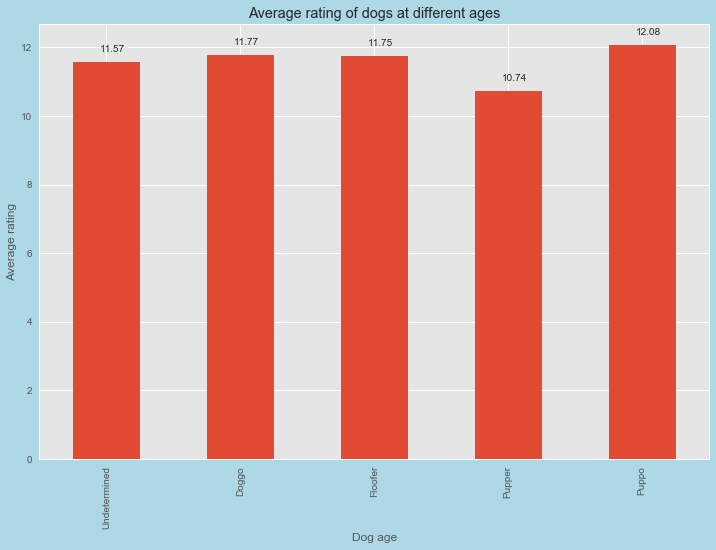

In [1422]:
fig = plt.subplots(figsize = (12,8),facecolor='lightblue')
ax = df_ta.query('rating_denominator == 10').groupby('dog_age_category').mean().rating_numerator.plot(kind='bar', ylabel='Average rating', xlabel='Dog age', title='Average rating of dogs at different ages');
ax.set_xticklabels(('Undetermined', 'Doggo', 'Floofer', 'Pupper', 'Puppo'))

for p in ax.patches:
    ax.annotate(str(p.get_height().round(2)), xy=(p.get_x()+0.2, p.get_height()+0.3))

The average ranking of dogs without age category assigned to them is: 11.57. Looking at the dog ages, most dogs of a certain age category have a higher than average ranking compared to the undetermined category. Puppos are the most liked with an average of 12.08. Puppers however have the lowest average ranking of any category. 

<a id='insight4'></a>
### Insight: Main sources of tweets:

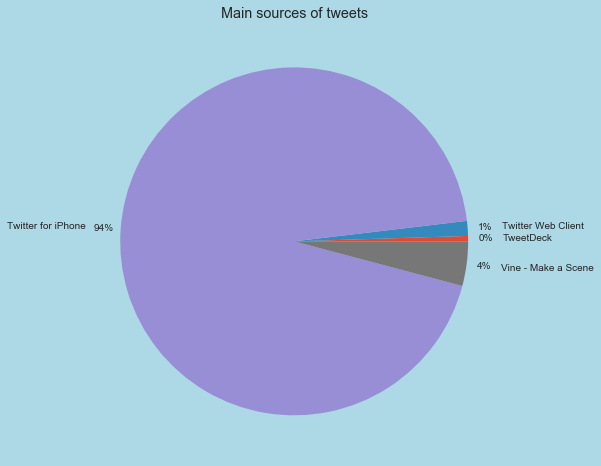

In [1423]:
fig = plt.subplots(figsize=(12,8), facecolor='lightblue')
ax = df_ta.groupby('source').sum().tweet_id.plot(kind='pie', title = 'Main sources of tweets', ylabel='', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)



The main source of tweets from the WeRateDogs twitter page have been posted from an iPhone - 94 %. 
4 % of posts come from Vine make a scene - a Twitter app, that allows twitter users to create and post short videos. 
1 % of posts originate from a Twitter Web Client - a twitter service or app that accesses Twitter through its API. 
Tweet deck was the least used, less than 1 percent. Tweet deck is a personal browser where several twitter accounts can be managed.

<a id='insight5'></a>
### Insight: Time analysis of mean monthly rating for ratings of single dogs (denominator = 10):

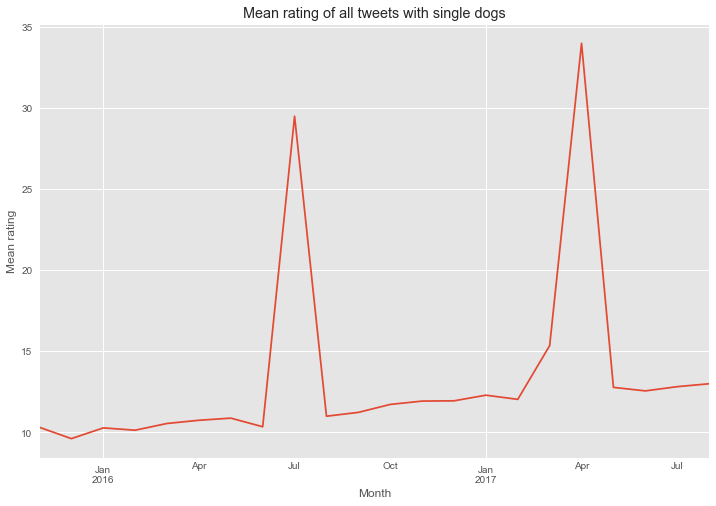

In [1424]:
##timeseries of monthly average ranking of all single dogs.
df_monthly = df_ta.query('rating_denominator == 10').resample('M', on='timestamp').rating_numerator.mean()
df_monthly.plot(figsize=(12,8), xlabel= 'Month', ylabel='Mean rating', title='Mean rating of all tweets with single dogs');

In [1425]:
df_monthly

timestamp
2015-11-30 00:00:00+00:00    10.316667
2015-12-31 00:00:00+00:00     9.618549
2016-01-31 00:00:00+00:00    10.280423
2016-02-29 00:00:00+00:00    10.138211
2016-03-31 00:00:00+00:00    10.553030
2016-04-30 00:00:00+00:00    10.750000
2016-05-31 00:00:00+00:00    10.881356
2016-06-30 00:00:00+00:00    10.351064
2016-07-31 00:00:00+00:00    29.484211
2016-08-31 00:00:00+00:00    11.000000
2016-09-30 00:00:00+00:00    11.235797
2016-10-31 00:00:00+00:00    11.726351
2016-11-30 00:00:00+00:00    11.932203
2016-12-31 00:00:00+00:00    11.948276
2017-01-31 00:00:00+00:00    12.295775
2017-02-28 00:00:00+00:00    12.038732
2017-03-31 00:00:00+00:00    15.350877
2017-04-30 00:00:00+00:00    33.979592
2017-05-31 00:00:00+00:00    12.777778
2017-06-30 00:00:00+00:00    12.560000
2017-07-31 00:00:00+00:00    12.820755
2017-08-31 00:00:00+00:00    13.000000
Freq: M, Name: rating_numerator, dtype: float64

Apart from two month (Jul 2016 and Apr 2017) with massive outliers, the mean rating of the dogs has increased with time. Starting around 10 and increasing to 13 in Sep 2017.

### Appendix:

Secure authorisation key outside of notebook:

http://veekaybee.github.io/2020/02/25/secrets/

https://pypi.org/project/python-dotenv/

http://docs.tweepy.org/en/latest/getting_started.html#api

https://www.w3resource.com/python-exercises/file/python-io-exercise-9.php

https://stackoverflow.com/questions/17322208/multiple-try-codes-in-one-block

https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

https://stackoverflow.com/questions/23591254/python-pandas-matplotlib-annotating-labels-above-bar-chart-columns